In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import joblib

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    precision_recall_curve,
    accuracy_score
)
from imblearn.over_sampling import SMOTE
from lightgbm import LGBMClassifier

In [4]:
df = pd.read_csv("data/Telco-Customer-Churn.csv")
if 'Unnamed: 0' in df.columns:
    df.drop(columns=['Unnamed: 0'], inplace=True)

In [5]:
# EDA
print("\nBasic Info:")
print(df.info())


Basic Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-nu

In [6]:
print("\nMissing Values:")
print(df.isnull().sum())


Missing Values:
customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64


In [7]:
print("\nTarget Distribution:")
print(df['Churn'].value_counts(normalize=True))


Target Distribution:
Churn
No     0.73463
Yes    0.26537
Name: proportion, dtype: float64


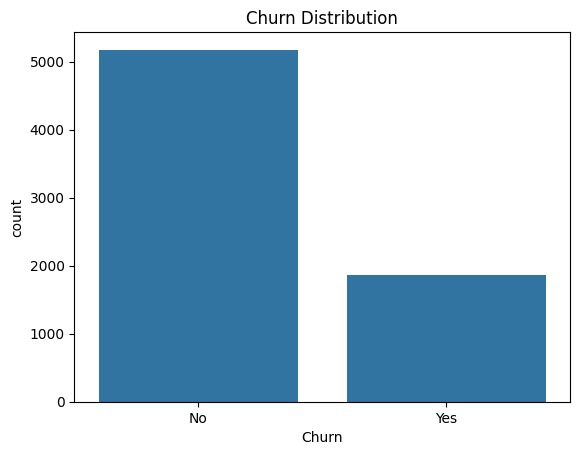

In [8]:
# Plot churn distribution
sns.countplot(x='Churn', data=df)
plt.title("Churn Distribution")
plt.show()

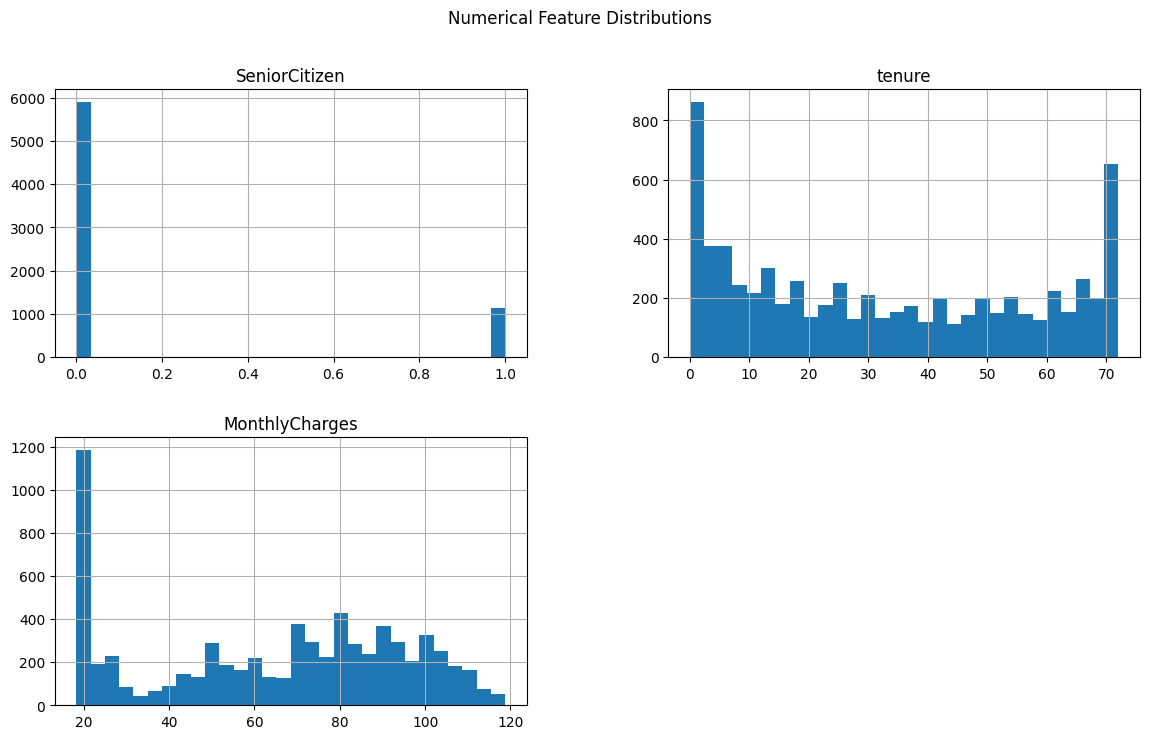

In [9]:
# Numerical feature distributions
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
df[numeric_cols].hist(bins=30, figsize=(14, 8))
plt.suptitle("Numerical Feature Distributions")
plt.show()

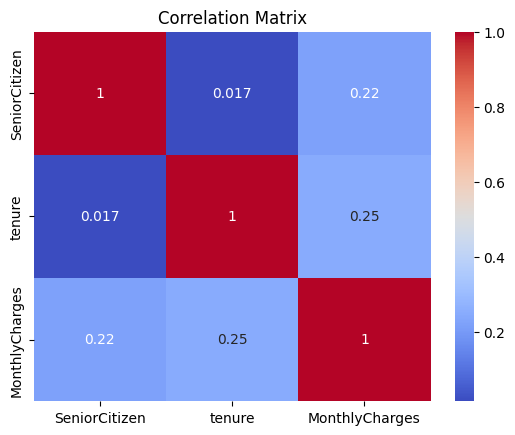

In [10]:
# Correlation matrix
corr = df[numeric_cols].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

In [11]:
# Preprocessing
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})

In [12]:
df.dropna(inplace=True)

In [13]:
if 'tenure' in df.columns:
    df['TenureGroup'] = pd.cut(
        df['tenure'],
        bins=[-1, 12, 24, 48, 60, 72],
        labels=["0-12", "13-24", "25-48", "49-60", "61-72"]
    )
    df.drop(columns=['tenure'], inplace=True)

In [14]:
for col in df.select_dtypes(include='object').columns:
    df[col] = df[col].replace({'No internet service': 'No', 'No phone service': 'No'})

In [15]:
for col in df.select_dtypes(include='object').columns:
    df[col] = df[col].astype('category')

In [16]:
# Encoding and resampling
X = df.drop('Churn', axis=1)
y = df['Churn']

In [17]:
X_encoded = pd.get_dummies(X, drop_first=True)

In [19]:
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_encoded, y)

In [21]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_res, y_res, test_size=0.2, stratify=y_res, random_state=42
)

In [23]:
# Model training
model = LGBMClassifier(random_state=42, class_weight='balanced', n_estimators=200)
model.fit(X_train, y_train)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4139, number of negative: 4139
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000856 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 311
[LightGBM] [Info] Number of data points in the train set: 8278, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


LGBMClassifier(class_weight='balanced', n_estimators=200, random_state=42)

In [24]:
# Threshold tuning
y_proba = model.predict_proba(X_test)[:, 1]

In [25]:
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
f1_scores = 2 * precision * recall / (precision + recall + 1e-8)
best_idx = np.argmax(f1_scores)
best_thresh = thresholds[best_idx]

In [26]:
y_pred = (y_proba >= best_thresh).astype(int)

In [27]:
# Evaluation
print(f"Best Threshold: {best_thresh:.2f}")
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"ROC-AUC: {roc_auc_score(y_test, y_proba)}")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Best Threshold: 0.48
Accuracy: 0.8270531400966183
ROC-AUC: 0.8968848747928773
Confusion Matrix:
 [[802 233]
 [125 910]]
Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.77      0.82      1035
           1       0.80      0.88      0.84      1035

    accuracy                           0.83      2070
   macro avg       0.83      0.83      0.83      2070
weighted avg       0.83      0.83      0.83      2070



In [29]:
# Save model
joblib.dump(model, 'model/churn_model.pkl')

with open('model/best_threshold.txt', 'w') as f:
    f.write(str(best_thresh))

joblib.dump(X_encoded.columns.tolist(), 'model/feature_columns.pkl')

['model/feature_columns.pkl']